# 4. Cluster the images & 6. Detect anomalies (Lennert Franssens)
## Part 2: Clustering with t-SNE

### Introduction

This is the second part of task 4. In this notebook we will do the actual clustering of the images, based on their feature vectors that we generated in part 1 of this task.<br><br>
Because of the clustering and the result that we get, we will also discuss task 6 (Detect anomalies) in this notebook based on the results from task 4.

But first we will import the needed libraries for this notebook.

In [1]:
import sys
!{sys.executable} -m pip install rasterfairy-py3

In [2]:
import numpy as np
import matplotlib.pyplot
import pickle
from matplotlib.pyplot import imshow
from PIL import Image
from sklearn.manifold import TSNE
import rasterfairy

%matplotlib inline

### Load feature vectors from part 1

We need the feature vectors, PCA and its features that we generated in part 1 of this task. Because we stored them in a file, we can load them again here.

In [3]:
images, pca_features, pca = pickle.load(open('data/features/features_from_one_folder.p', 'rb'))

In this part of the task we will make use of t-SNE, t-distributed stochastic neighbour embedding. t-SNE is a dimensionality reduction algorithm like PCA. With t-SNE we can separate data that cannot be separated by a straight line. More information about t-SNE can be found on https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a.

### Pass trough t-SNE

We now have the PCA features (of each image). We load them in a variable X. We pass the features through t-SNE. We project down to 2 dimensions (n_components). The iterations step size is set to 200 (learning_rate), the number of independent clusters is set to 75 (perplexity) and the speed/accuracy tradeoff (angle) is set to 0.1.

In [4]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=200, perplexity=75, angle=0.10, verbose=2).fit_transform(X)

[t-SNE] Computing 226 nearest neighbors...
[t-SNE] Indexed 10239 samples in 0.001s...
[t-SNE] Computed neighbors for 10239 samples in 2.556s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10239
[t-SNE] Computed conditional probabilities for sample 2000 / 10239
[t-SNE] Computed conditional probabilities for sample 3000 / 10239
[t-SNE] Computed conditional probabilities for sample 4000 / 10239
[t-SNE] Computed conditional probabilities for sample 5000 / 10239
[t-SNE] Computed conditional probabilities for sample 6000 / 10239
[t-SNE] Computed conditional probabilities for sample 7000 / 10239
[t-SNE] Computed conditional probabilities for sample 8000 / 10239
[t-SNE] Computed conditional probabilities for sample 9000 / 10239
[t-SNE] Computed conditional probabilities for sample 10000 / 10239
[t-SNE] Computed conditional probabilities for sample 10239 / 10239
[t-SNE] Mean sigma: 12.439465
[t-SNE] Computed conditional probabilities in 0.995s
[t-SNE] Iteration 50: error = 85.8

In the next cell, we normalize the points.

In [5]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

### Generate overview

With the t-SNE results, we can now make a visual overview of how the clusters relate to each other and which images belong to them.

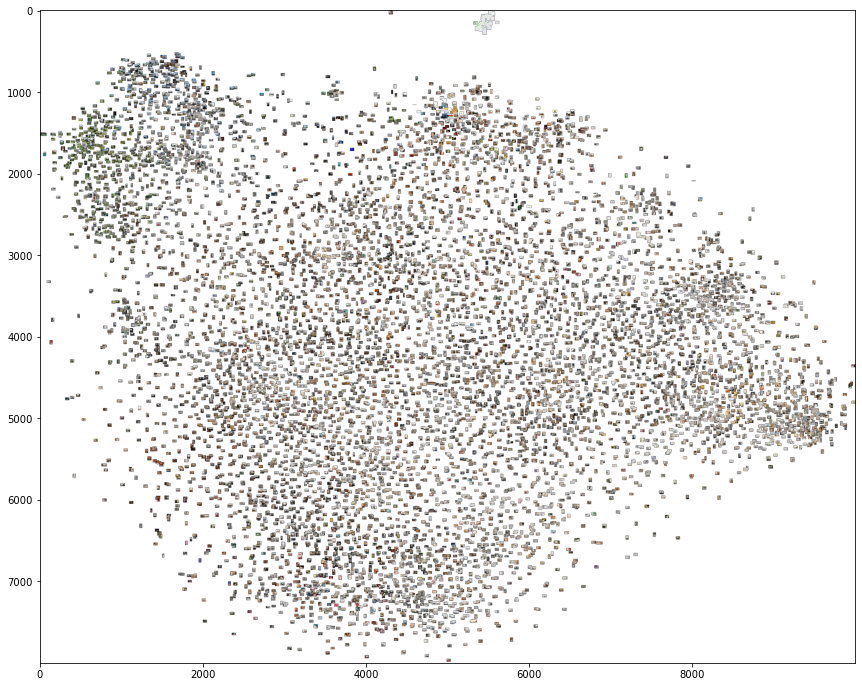

In [6]:
width = 10000
height = 8000
max_dim = 50

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

We clearly see that there is a huge cluster. That cluster innerly connects clusters because there are enough features that are are common in images between the clusters. The inner clusters can also be separated from each other. We see a cluster at the left top. That cluster holds all images that are taken outside. In that cluster there are also two inner-inner clusters. One cluster is about images from buildings. The other cluster has images from parks.<br><br>
We also see a clear separate cluster from the huge cluster. That small cluster contains screenshots from maps. That are clearly outliers and are therefore also separated from all other images that are available from our listings.<br><br>
On the outside of the big cluster, but near the separate 'outlier' cluster, we find also pictures that can also be seen as 'other images than others'. These images are logos, written messages, images of bicycles, house plans... These are more common (because they are shot in an interiour for example) but are also not completely like other pictures. That's why they are somwhere in the middle of 'outliers' and 'part of the big cluster'.

A picture clusters_indicated.png can be found in the root folder (and below). The green surface is the 'outlier' surface. The red surface is the 'in-between of outlier and big cluster' surface. And the yellow surface is the cluster of pictures that are shot outside.

![indicated clusters](./clusters_indicated.png)

We save the generated image to the file clusters.png.

In [7]:
full_image.save("clusters.png")

### RasterFairy to get a better overview

To get a better overview and bypass overlapping images, we can make a grid of the clusters. RasterFairy is a module that transforms a 2D point cloud to a regular raster whilst trying to preserve the neighborhoud relations that were present in the original cloud.<br><br>
We first define the size of our grid and then transform our original 2D point cloud to a grid.

In [8]:
nx = 102
ny = 102

grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

The following cell is used to plot our to grid transformed point cloud.

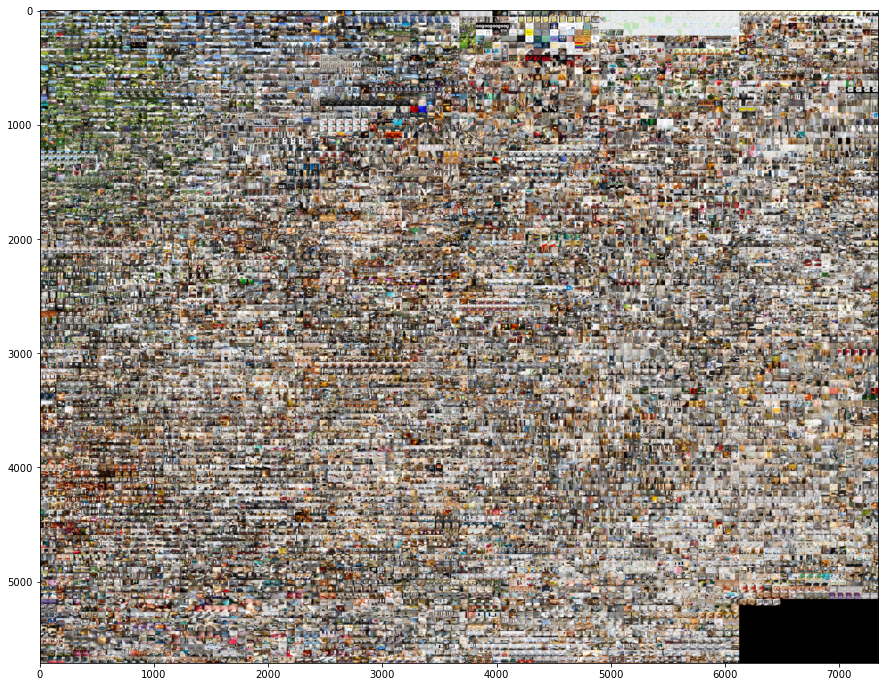

In [9]:
tile_width = 72
tile_height = 56

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)

We save the generated image to the file clusters_spread.png.

In [10]:
grid_image.save("clusters_spread.jpg")

References for this task:
* https://github.com/ml4a/ml4a/blob/master/examples/info_retrieval/image-search.ipynb
* https://github.com/ml4a/ml4a/blob/master/examples/info_retrieval/image-tsne.ipynb